# 2023-08-31__STA_conntest

So, hi.
copying from prev nb:

So, for all 10 Ns;\
For 10 diff seeds;
for both exc, inh, and unconn;\
we conntest (maximum) 100 input spike trains.\
(Each test is comprised of calculating 101 STAs: one real and the rest with shuffled ISIs).

In [18]:
include("lib/Nto1.jl")

[IJulia init done]
using Revise … ✔
using Units … ✔
using Nto1AdEx … ✔
using ConnectionTests … ✔
using ConnTestEval … ✔
using StatsBase … ✔


In [3]:
duration = 10minutes
N = 6500

@time sim = Nto1AdEx.sim(N, duration);

  2.462874 seconds (1.14 M allocations: 987.502 MiB, 1.91% gc time, 30.60% compilation time)


(So even with native code caching in Julia 1.9, we still have 30% of time compilation here).

We decided we'd pick the 100 highest firing (exc and inh).\
And then generate some unconnecteds too..\
What's their firing rate? Maybe sample from the real ones :) hehe, sure.

## Gen unconnected trains

In [22]:
set_print_precision(3)

In [30]:
exc_inputs = highest_firing(excitatory_inputs(sim))[1:100]
inh_inputs = highest_firing(inhibitory_inputs(sim))[1:100]
both = [exc_inputs..., inh_inputs...]
fr = spikerate.(both)
showsome(fr / Hz)

200-element Vector{Float64}:
   1: 97.5
   2: 58.9
   ⋮
  25: 22.6
   ⋮
 143: 12.6
   ⋮
 199: 8.87
 200: 8.86


In [90]:
Random.seed!(1)
unconn_frs = sample(fr, 100)
showsome(unconn_frs)

100-element Vector{Float64}:
   1: 25.9
   2: 17.1
   ⋮
  19: 17.7
   ⋮
  72: 11
   ⋮
  99: 10.4
 100: 8.92


Seed may not be same as seed in sim: otherwise our 'unconnected' trains generated might be same as real ones used in (generated in) sim.

In [91]:
Random.seed!(9)
unconn_trains = [poisson_SpikeTrain(r, duration) for r in unconn_frs];

## Conntest

In [92]:
ConnectionTests.set_STA_length(200);

In [93]:
test(train) = test_conn(STAHeight(), sim.V, train.times)

@time test(exc_inputs[1])

  0.527623 seconds (2.07 k allocations: 134.689 MiB)


0.99

(That value is the 'connectedness measure' I defined. Here simply 1 – p-value)

Plottin some unconnected STAs.

In [36]:
include("lib\\plot.jl")

import PythonCall … ✔ (2.3 s)
import PythonPlot … ✔ (4 s)
using Sciplotlib … ✔ (0.6 s)
using PhDPlots … ✔


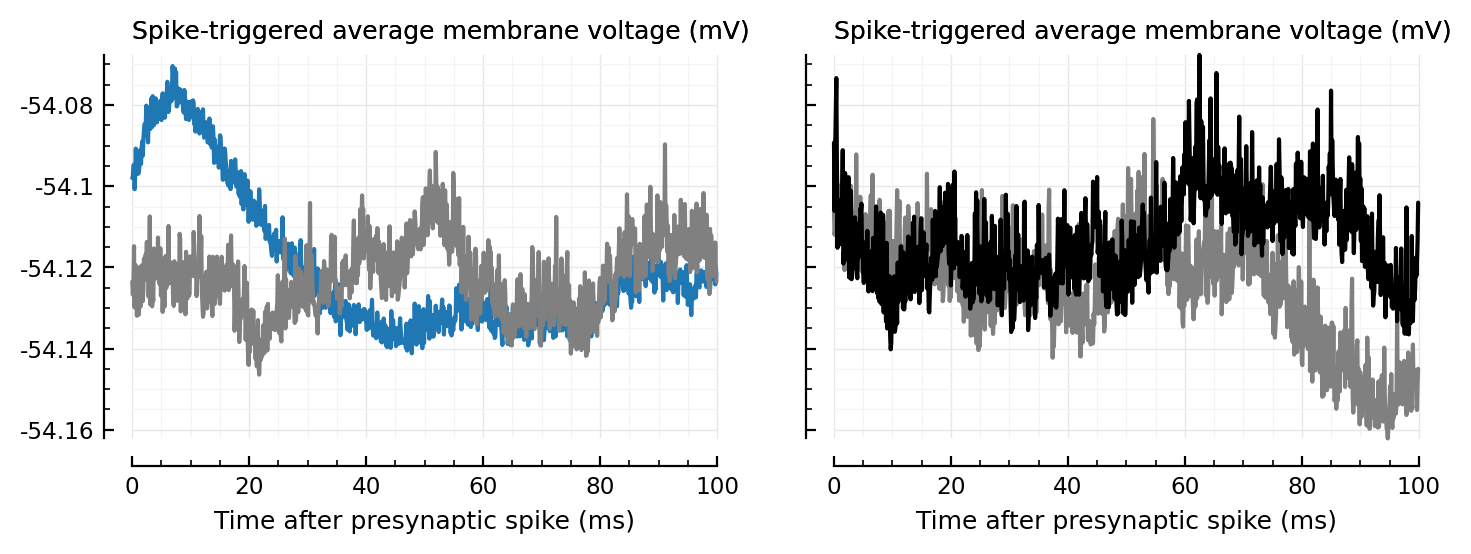

In [96]:
_plotSTA(train, winlength = 1000; kw...) = plotSTA(calc_STA(sim.V, train.times, Nto1AdEx.Δt, winlength); kw...);
fig, axs = plt.subplots(ncols=2, figsize=(pw, 0.3pw), sharey=true)
_plotSTA(exc_inputs[1], ax=axs[0])
_plotSTA(unconn_trains[1], ax=axs[0], c="gray")
_plotSTA(unconn_trains[2], ax=axs[1], c="gray")
_plotSTA(unconn_trains[3], ax=axs[1], c="black");

In [95]:
@time test.(unconn_trains[[1,2,3]])

  0.629688 seconds (37.91 k allocations: 80.817 MiB, 6.84% gc time)


3-element Vector{Float64}:
 -0.57
 -0.1
 -0.8

In [83]:
include("lib/df.jl")

using DataFrames … ✔


In [98]:
using ProgressMeter

In [123]:
rows = []

@time for (conntype, trains) in [
        (:exc, exc_inputs),
        (:inh, inh_inputs),
        (:unc, unconn_trains)
    ]
    descr = string(conntype)
    @showprogress descr for train in trains
        t = test(train)
        fr = spikerate(train)
        push!(rows, (; conntype, fr, t))
    end
end;

exc 100%|████████████████████████████████████████████████| Time: 0:00:25
inh 100%|████████████████████████████████████████████████| Time: 0:00:18
unc 100%|████████████████████████████████████████████████| Time: 0:00:21
 66.128109 seconds (262.17 k allocations: 7.042 GiB, 0.99% gc time)


In [126]:
showsome(rows)

300-element Vector{Any}:
   1: (conntype = :exc, fr = 97.5, t = 0.99)
   2: (conntype = :exc, fr = 58.9, t = 0.91)
   ⋮
 164: (conntype = :inh, fr = 10.8, t = -0.81)
   ⋮
 184: (conntype = :inh, fr = 9.75, t = -0.9)
   ⋮
 299: (conntype = :unc, fr = 10.3, t = 0.7)
 300: (conntype = :unc, fr = 8.81, t = 0.75)


In [127]:
df = DataFrame(rows)
rename!(df, :fr => "Spikerate (Hz)")

Row,conntype,Spikerate (Hz),t
,Symbol,Float64,Float64
1,exc,97.5,0.99
2,exc,58.9,0.91
3,exc,40.7,0.98
4,exc,34.4,0.86
5,exc,31.5,0.99
⋮,⋮,⋮,⋮
296,unc,9.21,-0.95
297,unc,16.4,0.26
298,unc,8.98,-0.33


## Eval

In [129]:
sweep = ConnTestEval.sweep_threshold(df);

In [139]:
showsome(sweep.threshold)

86-element Vector{Float64}:
  1: 0.99
  2: 0.98
  ⋮
 30: 0.7
  ⋮
 32: 0.68
  ⋮
 85: 0.03
 86: 0


In [158]:
23/100

0.23

In [140]:
predtable = at_FPR(sweep, 5/100)
print_confusion_matrix(predtable)

              Predicted
           exc   inh   unc
      exc   23     3    74
Real  inh    0    40    60
      unc    4     2    94



In [238]:
AUCs = calc_AUROCs(sweep)
AUCs = (; (k=>round(AUCs[k], digits=2) for k in keys(AUCs))...)

(AUC = 0.77, AUCₑ = 0.68, AUCᵢ = 0.86)

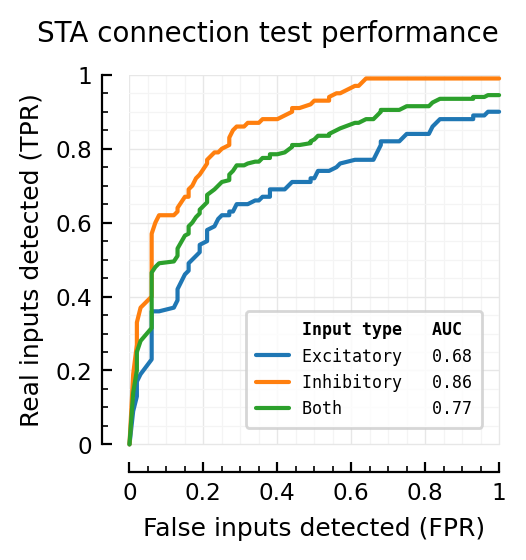

In [327]:
fig, ax = plt.subplots()
set(ax, aspect="equal", xlabel="False inputs detected (FPR)", ylabel="Real inputs detected (TPR)",
    xtype=:fraction, ytype=:fraction, title=("STA connection test performance", :pad=>12, :loc=>"right"))
# ax.axvline(0.05, color="gray", lw=1)
plot(sweep.FPR, sweep.TPRₑ; ax, label="Excitatory   $(AUCs.AUCₑ)")
plot(sweep.FPR, sweep.TPRᵢ; ax, label="Inhibitory   $(AUCs.AUCᵢ)")
plot(sweep.FPR, sweep.TPR; ax,  label="Both         $(AUCs.AUC)")
font = Dict("family"=>"monospace", "size"=>6)
legend(ax, borderaxespad=1,     title="Input type   AUC ", loc="lower right",
        alignment="right", markerfirst=true, prop=font);
# Using the same `font` dict for `title_fontproperties` does not apply the size (bug ig)
# (bug in this PR? https://github.com/matplotlib/matplotlib/pull/19304)
# Hm, it works in straight Python[*]. Interesting.
ax.legend_.get_title().set(family="monospace", size=6, weight="bold");

[*]: http://localhost:8888/notebooks/2023-09-05__mpl_legend_title_props_bugreport.ipynb

`[*]`: http://localhost:8888/notebooks/2023-09-05__mpl_legend_title_props_bugreport.ipynb

In [179]:
neighbours_of_5pct_line = sweep[5:6]
neighbours_of_5pct_line.threshold

2-element Vector{Float64}:
 0.95
 0.94

In [180]:
neighbours_of_5pct_line.FPR

2-element Vector{Float64}:
 0.03
 0.06

Sudden jump in TPRs right around 5%.\
Coincidence I think, cause there is no threshold programmed in STAHeight ConnectionTest.

Actually no, jump is after 5% / at 6%:

In [206]:
x = sweep[5:11]
DataFrame(; x.threshold, x.FPR, x.TPR)

Row,threshold,FPR,TPR
,Float64,Float64,Float64
1,0.95,0.03,0.28
2,0.94,0.06,0.315
3,0.93,0.06,0.335
4,0.92,0.06,0.4
5,0.91,0.06,0.44
6,0.9,0.06,0.465
7,0.89,0.07,0.48


So we increase the threshold from 0.94 to 0.90, and find more TPs, without incurring any additional FPs.